In [1]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from os.path import exists

In [2]:
i = 0
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]

In [3]:
test = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   image_dimension=config['image_dimension'])

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.


In [4]:
y_true = hf.get_y_true(shape=(test.samples, len(test.class_indices)), classes=test.classes)

Unweighted mean imbalance ratio: 40.97


<ipython-input-24-d13606039ac1>:22: RuntimeWarning: divide by zero encountered in true_divide
  label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0)
<ipython-input-24-d13606039ac1>:23: RuntimeWarning: invalid value encountered in multiply
  image_rewards = (label_rewards * y_true_copy).sum(axis=1)


Unweighted mean imbalance ratio: 24.78


Text(0.5, 0, 'Label')

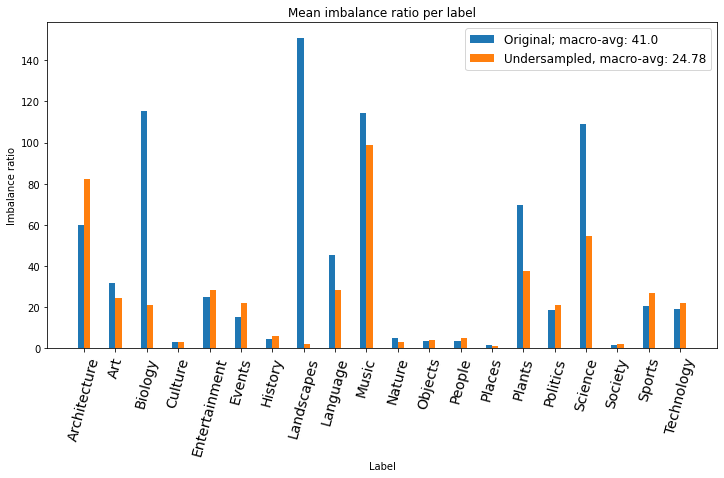

In [24]:
# Construct balanced dataset starting from test
label_names = list(test.class_indices.keys())
ir_original = hf.imbalance_ratio(y_true=y_true, class_names=label_names)

BIG_NUMBER = 40_000
MIN_IMAGES = 1_000

y_true_copy = np.copy(y_true)
label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0)
image_rewards = (label_rewards * y_true_copy).sum(axis=1)
indices_to_add = []

while len(indices_to_add) < MIN_IMAGES:
    # Select the image with greatest reward
    highest_reward_image_idx = np.argmax(image_rewards)
    # Get index of this image in the original array
    all_matching_indices_in_original_array = np.where((y_true == y_true_copy[highest_reward_image_idx, :]).all(axis=1))[0]
    idx_to_add = np.setdiff1d(all_matching_indices_in_original_array, indices_to_add)[0]
    indices_to_add.append(idx_to_add)
    # Prepare for next iteration:
    y_true_copy = np.delete(y_true_copy, highest_reward_image_idx, axis=0)
    label_rewards = BIG_NUMBER / y_true_copy.sum(axis=0)
    image_rewards = (label_rewards * y_true_copy).sum(axis=1)

y_true_balanced = y_true[indices_to_add, :]

ir_heuristics = hf.imbalance_ratio(y_true=y_true_balanced, class_names=label_names)
    
plt.figure(figsize=(12, 6))
x_axis = np.arange(len(ir_original[0].keys()))
plt.bar(x_axis-0.1, ir_original[0].values(), width=0.2, label=f'Original; macro-avg: {np.round(ir_original[1], 1)}')
plt.bar(x_axis+0.1, ir_heuristics[0].values(), width=0.2, label=f'Undersampled, macro-avg: {np.round(ir_heuristics[1], 2)}')
plt.legend(fontsize=12)
_ = plt.xticks(x_axis, ir_original[0].keys(), rotation=75, fontsize=14)
plt.title('Mean imbalance ratio per label')
plt.ylabel('Imbalance ratio')
plt.xlabel('Label')

Plot distributions

In [20]:
def plot_dist(y_true, label_names):
    sorted_indices = np.argsort(np.sum(y_true, axis=0))
    sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]

    _ = plt.figure(figsize=(8, 14))

    _ = plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='purple', alpha=0.6)

    _ = plt.yticks(range(y_true.shape[1]), np.array(label_names)[sorted_indices], fontsize=12)
    # _ = plt.xscale('log')
    _ = plt.xlabel('Count', fontsize=13)
    _ = plt.ylabel('Labels', fontsize=13)
    _ = plt.grid(True)

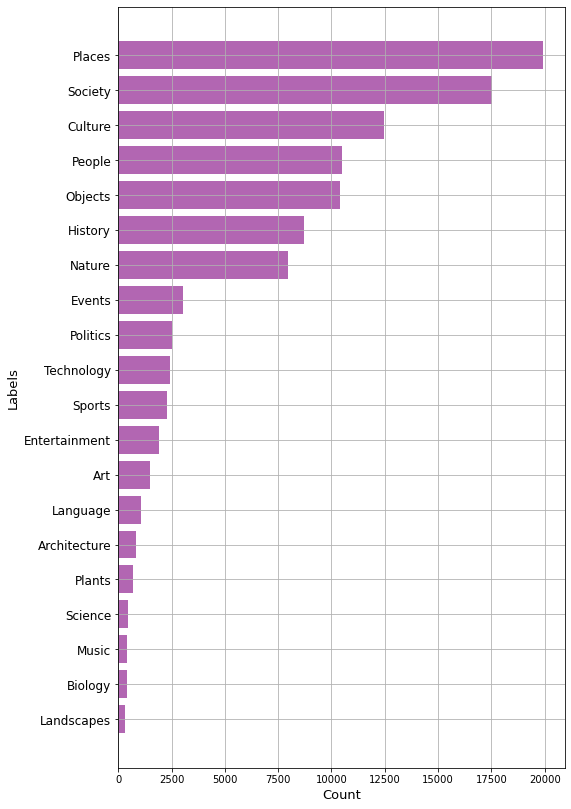

In [21]:
plot_dist(y_true, label_names)

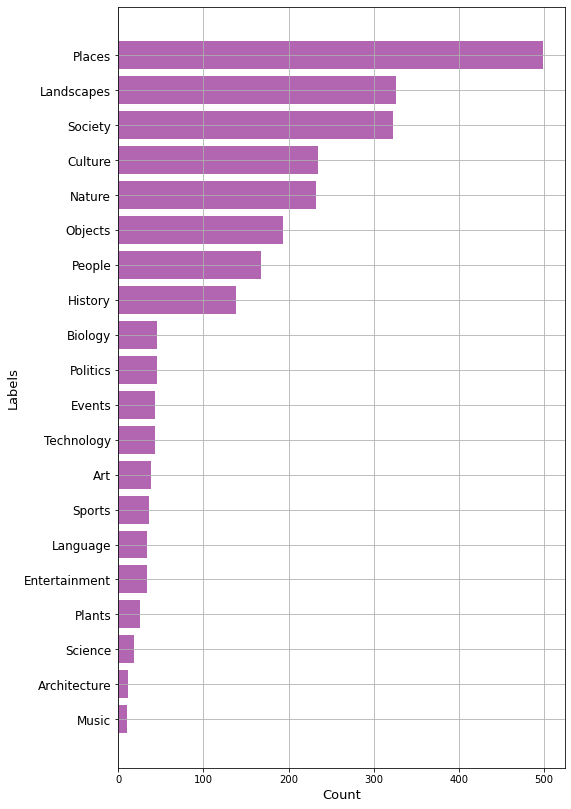

In [22]:
plot_dist(y_true_balanced, label_names)
